In [1]:
import geomstats.backend as gs
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
import geomstats.datasets.utils as data_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

INFO: Using numpy backend


## Loading data

There are 28 sets of landmarks: 14 healthy controls and 14 schizophrenic patients.


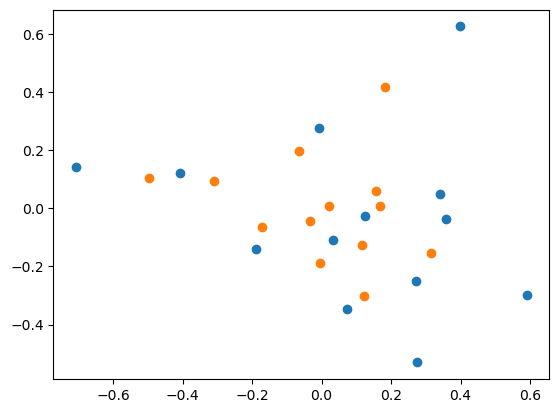

In [2]:
def load_schizophrenia_data() :
    """Load data from schizophrenia_data.csv.
    
    Load the dataset of sets of 13 landmarks, labelled 1-13, in 2D on patients brain data
    - (1) splenium, posteriormost point on corpus callosum
    - (2) genu, anteriormost point on corpus callosum
    - (3) top of corpus callosum, uppermost point on arch of callosum (all three to an approximate registration on the diameter of the callosum)
    - (4) top of head, a point relaxed from a standard landmark along the apparent margin of the dura
    - (5) tentorium of cerebellum at dura
    - (6) top of cerebellum; (7) tip of fourth ventricle
    - (8) bottom of cerebellum
    - (9) top of pons, anterior margin
    - (10) bottom of pons, anterior margin
    - (11) optic chiasm
    - (12) frontal pole, extension of a line from #1 through #2 until it intersects the dura
    - (13) superior colliculus
    
    Label 0 refers to a "normal" patient, and Label 1 to an patient with schizophrenia.
    
    References
    ----------
    .. https://sbmorphometrics.org/data/book-schizo.dta
    .. Bookstein, F.L. Biometrics, biomathematics and the morphometric synthesis. Bltn Mathcal Biology 58, 313–365 (1996). https://doi.org/10.1007/BF02458311
        
    Returns
    -------
    data : array-like, shape = [28, 13, 2]
        Data representing the 13 landmarks, in 2D, for 28 different patients.
    labels : array-like, shape = [28,]
        Labels in {0, 1} classifying the corresponding patient as normal (label = 0) or schizophrenic (label = 1).
    pateints : array-like, shape = [28,]
        Indices in 0...28 referencing the index of the patient to which the data belongs.
    """
    
    brains = pd.read_csv('schizophrenia_data.csv', header = 0, index_col = 0)
    brains_gs = brains.to_numpy(dtype = 'float64')

    data = gs.reshape(brains_gs, (28, 13, 2))
    labels = np.append(gs.zeros(14), gs.ones(14))
    patients = gs.arange(28)

    return data, labels, patients

brains, labels, patients = load_schizophrenia_data()
print(f"There are {len(labels)} sets of landmarks:"
      f" {sum(labels==0)} healthy controls and {sum(labels==1)} schizophrenic patients.")
    
m_ambient = 2
k_landmarks = 13
preshape = PreShapeSpace(m_ambient = m_ambient, k_landmarks = k_landmarks)
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)
    
landmarks_preshape = preshape.projection(brains)
landmarks_shape = preshape.align(point=landmarks_preshape, base_point=landmarks_preshape[0])

plt.scatter(brains[2,:,0],brains[2,:,1])
plt.scatter(landmarks_shape[2,:,0],landmarks_shape[2,:,1])
#print(labels)

## Splitting data into train and test

In [11]:
from sklearn.model_selection import train_test_split

X = landmarks_shape; y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"The dataset has {len(X)} landmarks.")
print(f"The train set has {len(X_train)} landmarks.")
print(f"The test set has {len(X_test)} landmarks.")

The dataset has 28 landmarks.
The train set has 21 landmarks.
The test set has 7 landmarks.


## Performing Logistic Regression - always very bad results, classifies everything as 0 (or 1)

In [12]:
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=kendall_metric)),
        ("classifier", LogisticRegression()),
    ]
)

lr_pipeline.fit(X_train, y_train)

print(f"Logistic regression score: {lr_pipeline.score(X_test, y_test):.2f}.")
print(lr_pipeline.predict(X_test))
print(y_test)

Logistic regression score: 0.43.
[1. 1. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 0. 1. 0.]


## Using K - nearest neighbours classifier
Accuracy upto 85 %

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=kendall_metric)),
        ("classifier", KNeighborsClassifier()),
    ]
)

knn_pipeline.fit(X_train, y_train)
print(f"K nearest neighbours score: {knn_pipeline.score(X_test, y_test):.2f}.")

print(knn_pipeline.predict(X_test))
print(y_test)

K nearest neighbours score: 0.86.
[0. 0. 1. 1. 1. 1. 0.]
[0. 0. 1. 1. 0. 1. 0.]


## Using classification on the manifold
Accuracy upto 85 %

In [14]:
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean

mdm = RiemannianMinimumDistanceToMean(
    riemannian_metric=kendall_metric)
mdm.fit(X_train, y_train)
print(f"Manifold learning score: {mdm.score(X_test, y_test):.2f}")
print(mdm.predict(X_test))
print(y_test)

Manifold learning score: 0.71
[0. 0. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 0. 1. 0.]


## Adding noise and testing again
For Knn and manifold classification

In [15]:
def shot_noise(set_of_landmarks, probability, sigma) :
    """Add gaussian shot noise to a data set of landmarks
    
    Parameters
    ----------
    set_of_landmarks : array-like
        Original data set
    probability : float, in the range 0 to 1
        Probability of getting introducing an error at each landmark
    sigma : float
        Sigma of the Gaussian distribution
​
    Returns
    -------
    noisy_data : array-like, of same dimensions as set_of_landmarks
        Data set with noise added to the original set of landmarks
    """
    rand_choice = gs.random.choice([0, 1], set_of_landmarks.shape, p = [1 - probability, probability])
    rand_norm = gs.random.normal(0.0, sigma, size = set_of_landmarks.shape)
    noisy_data = set_of_landmarks + rand_norm * rand_choice
    
    return noisy_data

In [16]:
probability = 0.3
sigma = 0.3
noisy_train = shot_noise(X_train, probability, sigma)
noisy_test = shot_noise(X_test, probability, sigma)

In [17]:
knn_pipeline.fit(noisy_train, y_train)
knn_score = knn_pipeline.score(noisy_test, y_test)
print(f"K nearest neighbours score: {knn_score:.2f}.")
print(knn_pipeline.predict(noisy_test))
print(y_test)

mdm.fit(noisy_train, y_train)
mdm_score = mdm.score(noisy_test, y_test)
print(f"Manifold learning score: {mdm_score:.2f}")
print(mdm.predict(noisy_test))
print(y_test)

K nearest neighbours score: 0.43.
[1. 1. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 0. 1. 0.]
Manifold learning score: 0.86
[0. 1. 1. 1. 0. 1. 0.]
[0. 0. 1. 1. 0. 1. 0.]


## Reapeating the process many times to see some trends

In [18]:
def get_lr_accuracies(probability,sigma,runs):
    lr_scores = []; lr_scores_noisy = []
    
    for iter in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        noisy_train = shot_noise(X_train, probability, sigma)
        noisy_test = shot_noise(X_test, probability, sigma)

        lr_pipeline.fit(X_train, y_train)
        lr_scores.append(lr_pipeline.score(X_test, y_test))
        lr_pipeline.fit(noisy_train, y_train)
        lr_scores_noisy.append(lr_pipeline.score(noisy_test, y_test))

    return lr_scores, lr_scores_noisy

def get_knn_accuracies(probability,sigma,runs):
    knn_scores = []; knn_scores_noisy = []
    
    for iter in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        noisy_train = shot_noise(X_train, probability, sigma)
        noisy_test = shot_noise(X_test, probability, sigma)

        knn_pipeline.fit(X_train, y_train)
        knn_scores.append(knn_pipeline.score(X_test, y_test))
        knn_pipeline.fit(noisy_train, y_train)
        knn_scores_noisy.append(knn_pipeline.score(noisy_test, y_test))

    return knn_scores, knn_scores_noisy

def get_mdm_accuracies(probability,sigma,runs):
    mdm_scores = []; mdm_scores_noisy = []
    
    for iter in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        noisy_train = shot_noise(X_train, probability, sigma)
        noisy_test = shot_noise(X_test, probability, sigma)

        mdm.fit(X_train, y_train)
        mdm_scores.append(mdm.score(X_test, y_test))
        mdm.fit(noisy_train, y_train)
        mdm_scores_noisy.append(mdm.score(noisy_test, y_test))

    return mdm_scores, mdm_scores_noisy

In [19]:
probabilities = [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0]
sigmas = [0.02, 0.04, 0.06, 0.08, 0.10, 0.15, 0.20, 0.25]

In [20]:
runs = 20
knn_scores_noisy_p = np.empty((len(probabilities), runs))
knn_scores_noisy_s = np.empty((len(sigmas), runs))

for iter, probability in enumerate(probabilities):
    knn_scores, knn_scores_noisy_p[iter] = get_knn_accuracies(probability=probability, sigma=0.2, runs=runs)

for iter, sigma in enumerate(sigmas):
    _, knn_scores_noisy_s[iter] = get_knn_accuracies(probability=0.3, sigma=sigma, runs=runs)

Text(0.5, 1.0, 'KNN - Histogram of mean accuracy for some probability values')

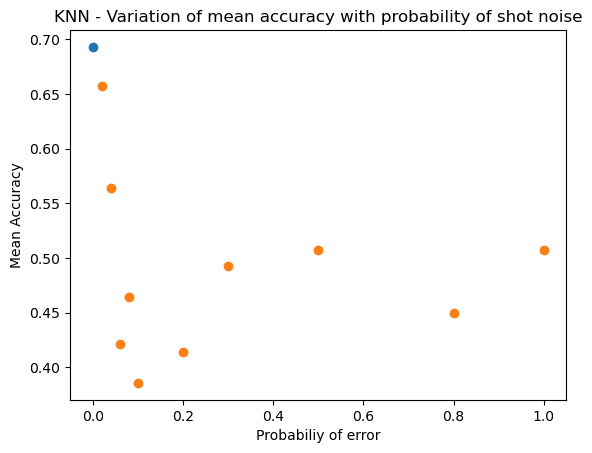

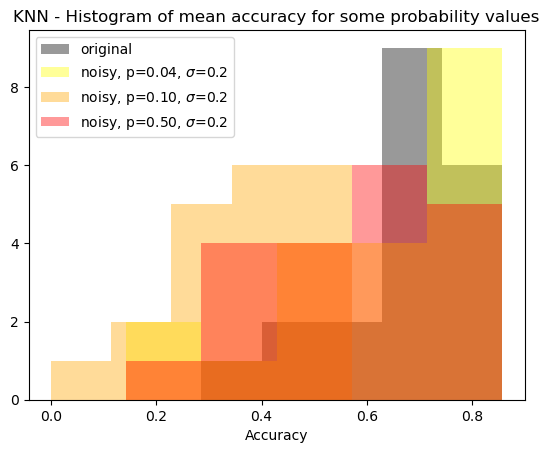

In [21]:
plt.figure()
plt.scatter(0,np.mean(knn_scores))
plt.scatter(probabilities, np.mean(knn_scores_noisy_p, axis=1))
plt.xlabel('Probabiliy of error')
plt.ylabel('Mean Accuracy')
plt.title('KNN - Variation of mean accuracy with probability of shot noise')

plt.figure()
bins = 5
plt.hist(knn_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(knn_scores_noisy_p[1], bins, alpha=0.4, label=f'noisy, p={probabilities[1]:.2f}, $\sigma$=0.2', color='yellow')
plt.hist(knn_scores_noisy_p[4], bins, alpha=0.4, label=f'noisy, p={probabilities[4]:.2f}, $\sigma$=0.2', color='orange')
plt.hist(knn_scores_noisy_p[7], bins, alpha=0.4, label=f'noisy, p={probabilities[7]:.2f}, $\sigma$=0.2', color='red')
plt.xlabel('Accuracy')
plt.legend()
plt.title('KNN - Histogram of mean accuracy for some probability values')

Text(0.5, 1.0, 'KNN - Histogram of mean accuracy for some $\\sigma$ values')

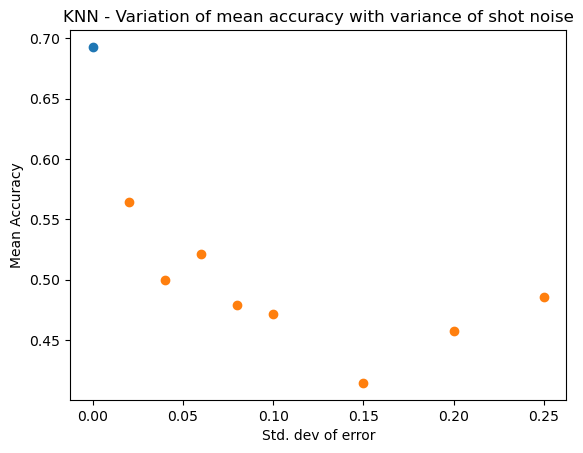

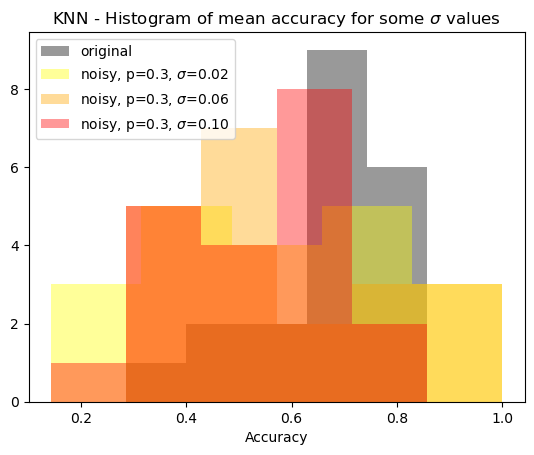

In [29]:
plt.scatter(0, np.mean(knn_scores))
plt.scatter(sigmas, np.mean(knn_scores_noisy_s, axis=1))
plt.xlabel('Std. dev of error')
plt.ylabel('Mean Accuracy')
plt.title('KNN - Variation of mean accuracy with variance of shot noise')

plt.figure()
bins = 5
plt.hist(knn_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(knn_scores_noisy_s[0], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[0]:.2f}', color='yellow')
plt.hist(knn_scores_noisy_s[2], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[2]:.2f}', color='orange')
plt.hist(knn_scores_noisy_s[4], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[4]:.2f}', color='red')
plt.xlabel('Accuracy')
plt.legend()
plt.title('KNN - Histogram of mean accuracy for some $\sigma$ values')

In [23]:
runs = 50
mdm_scores_noisy_p = np.empty((len(probabilities), runs))
mdm_scores_noisy_s = np.empty((len(sigmas), runs))

for iter, probability in enumerate(probabilities):
    mdm_scores, mdm_scores_noisy_p[iter] = get_mdm_accuracies(probability=probability, sigma=0.2, runs=runs)

for iter, sigma in enumerate(sigmas):
    _, mdm_scores_noisy_s[iter] = get_mdm_accuracies(probability=0.3, sigma=sigma, runs=runs)

Text(0.5, 1.0, 'MDM - Histogram of mean accuracy for some probability values')

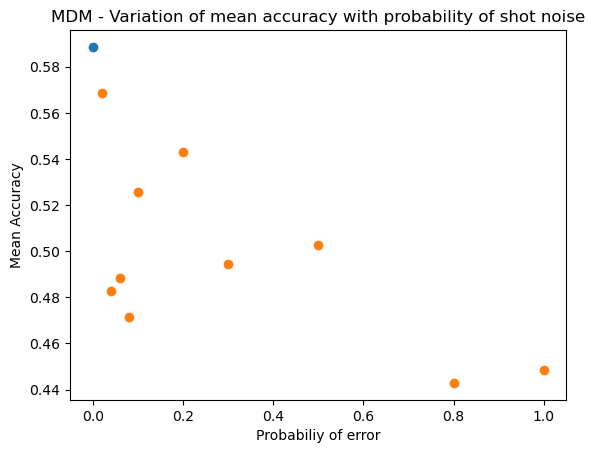

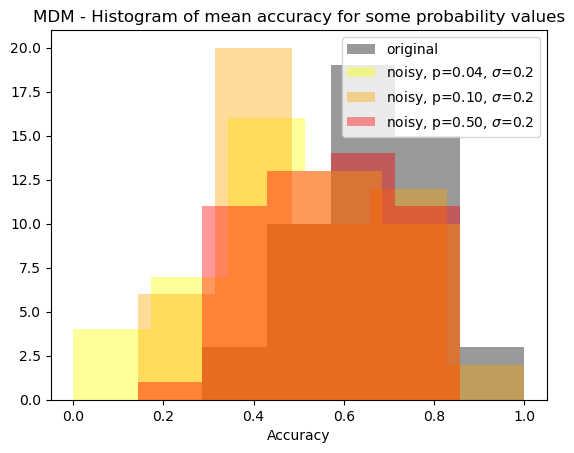

In [25]:
plt.figure()
plt.scatter(0,np.mean(mdm_scores))
plt.scatter(probabilities, np.mean(mdm_scores_noisy_p, axis=1))
plt.xlabel('Probabiliy of error')
plt.ylabel('Mean Accuracy')
plt.title('MDM - Variation of mean accuracy with probability of shot noise')

plt.figure()
bins = 5
plt.hist(mdm_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(mdm_scores_noisy_p[1], bins, alpha=0.4, label=f'noisy, p={probabilities[1]:.2f}, $\sigma$=0.2', color='yellow')
plt.hist(mdm_scores_noisy_p[4], bins, alpha=0.4, label=f'noisy, p={probabilities[4]:.2f}, $\sigma$=0.2', color='orange')
plt.hist(mdm_scores_noisy_p[7], bins, alpha=0.4, label=f'noisy, p={probabilities[7]:.2f}, $\sigma$=0.2', color='red')
plt.xlabel('Accuracy')
plt.legend()
plt.title('MDM - Histogram of mean accuracy for some probability values')

Text(0.5, 1.0, 'MDM - Histogram of mean accuracy for some $\\sigma$ values')

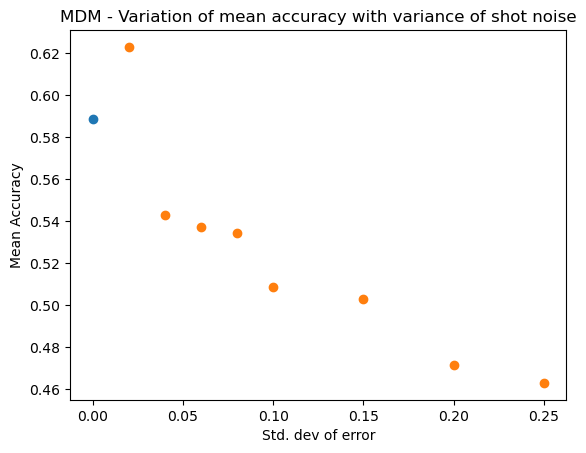

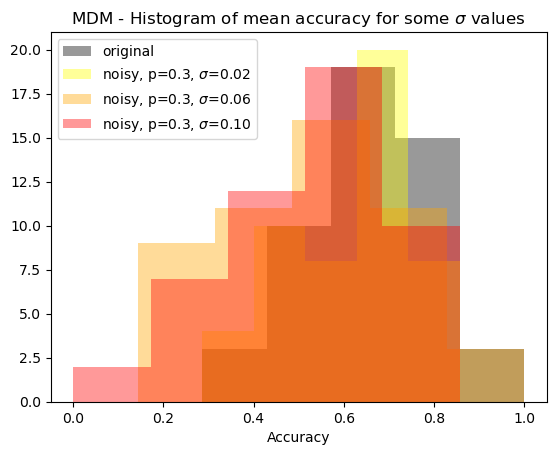

In [26]:
plt.scatter(0, np.mean(mdm_scores))
plt.scatter(sigmas, np.mean(mdm_scores_noisy_s, axis=1))
plt.xlabel('Std. dev of error')
plt.ylabel('Mean Accuracy')
plt.title('MDM - Variation of mean accuracy with variance of shot noise')

plt.figure()
bins = 5
plt.hist(mdm_scores, bins,alpha=0.4, label='original', color='black')
plt.hist(mdm_scores_noisy_s[0], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[0]:.2f}', color='yellow')
plt.hist(mdm_scores_noisy_s[2], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[2]:.2f}', color='orange')
plt.hist(mdm_scores_noisy_s[4], bins, alpha=0.4, label=f'noisy, p=0.3, $\sigma$={sigmas[4]:.2f}', color='red')
plt.xlabel('Accuracy')
plt.legend()
plt.title('MDM - Histogram of mean accuracy for some $\sigma$ values')